In [7]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import joblib
from itables import show

# Modely a metriky
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import precision_recall_curve, auc

# Automatické přenačítání modulů při změně
%load_ext autoreload
%autoreload 2

# Přidání složky 'src' do cesty Pythonu
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import našich modulů
import config
import load_preprocess_data as loader 
import analysis
from models import MahalanobisDetector, IsolationForestWrapper, OCSVMWrapper
import visualization as viz
viz.setup_style()

print("✅ Environment Ready.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
🎨 Vizualizační styl nastaven: whitegrid
✅ Environment Ready.


### Data Loading Funkce

In [ ]:
def load_sentence_vectors(pooling_method, scenario='baseline', test_size=0.2, random_state=42):
    """
    Načte větné vektory (Mean nebo CLS).
    """
    # Cesta: data/vectors/gold/gold_sent_mean_l0.pkl
    path_gold_l0 = config.VECTORS_DIR / 'gold' / f"gold_sent_{pooling_method}_l0.pkl"
    path_gold_l1 = config.VECTORS_DIR / 'gold' / f"gold_sent_{pooling_method}_l1.pkl"
    
    if not path_gold_l0.exists():
        raise FileNotFoundError(f"Vektory nenalezeny: {path_gold_l0}")

    # 1. Načtení GOLD dat
    with open(path_gold_l0, 'rb') as f: X_l0 = pickle.load(f)
    with open(path_gold_l1, 'rb') as f: X_l1_gold = pickle.load(f)
        
    # 2. Split L0 (Train vs Test)
    X_train_l0, X_test_l0 = train_test_split(X_l0, test_size=test_size, random_state=random_state)
    
    # 3. Sestavení L1 (Anomálie)
    if scenario == 'baseline':
        X_test_l1 = X_l1_gold
    
    elif scenario == 'robustness':
        path_silver_l1 = config.VECTORS_DIR / 'silver' / f"silver_sent_{pooling_method}_l1.pkl"
        if not path_silver_l1.exists():
            # Fallback pro případné jiné pojmenování
            path_silver_l1 = config.VECTORS_DIR / 'silver' / f"silver_sent_{pooling_method}_l1.pkl"
            
        if path_silver_l1.exists():
            with open(path_silver_l1, 'rb') as f: X_l1_silver = pickle.load(f)
            X_test_l1 = np.concatenate([X_l1_gold, X_l1_silver])
        else:
             print(f"⚠️ Warning: Silver data nenalezena ({path_silver_l1}), používám jen Gold.")
             X_test_l1 = X_l1_gold

    # 4. Finalizace
    X_test = np.concatenate([X_test_l0, X_test_l1])
    y_test = np.concatenate([np.zeros(len(X_test_l0)), np.ones(len(X_test_l1))])
    
    return X_train_l0, X_test, y_test

### Grid Search Loop

In [ ]:
# --- KONFIGURACE S2 EXPERIMENTU ---
POOLING_METHODS = ['mean', 'cls'] # Zde iterujeme přes pooling, ne přes filtry
SCENARIOS = ['baseline', 'robustness']

RESULTS_PATH = config.RESULTS_DIR / "M1_S2_experiment_results.csv"

# Grid Search Parametry (Stejné jako v S1)
param_grid = {
    'MD': [{'method': 'robust'}, {'method': 'empirical'}],
    'IF': [
        {'contamination': 0.001, 'n_estimators': 100}, 
        {'contamination': 0.01,  'n_estimators': 100},
        {'contamination': 0.05,  'n_estimators': 100}
    ],
    'OCSVM': [
        {'nu': 0.01, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.10, 'kernel': 'rbf', 'gamma': 'scale'}
    ]
}

# Sloupce pro CSV
ALL_COLUMNS = [
    'scenario', 'pooling', 'model', 
    'auprc', 'max_f1', 
    'method', 'contamination', 'n_estimators', 'nu', 'kernel', 'gamma'
]

In [ ]:
# %%script false          # Buňka je přeskočena, ať netrénujeme pokaždé. 

# Pokud soubor s výsledky už existuje, smažeme ho (startujeme nanovo)
if RESULTS_PATH.exists():
    RESULTS_PATH.unlink()
    print(f"🗑️ Starý soubor s výsledky smazán: {RESULTS_PATH}")

# Inicializace CSV s hlavičkou
pd.DataFrame(columns=ALL_COLUMNS).to_csv(RESULTS_PATH, index=False)
print(f"🚀 STARTING ALL-IN-ONE EXPERIMENT LOOP")
print(f"💾 Výsledky se ukládají do: {RESULTS_PATH}\n")

for scenario in SCENARIOS:
    print(f"\n🌍 SCÉNÁŘ: {scenario.upper()}")
    
    for pooling in POOLING_METHODS:
        print(f"\n   🧠 Pooling: {pooling.upper()}")
        
        try:
            X_train, X_test, y_test = load_sentence_vectors(pooling, scenario=scenario)
            print(f"      -> Data: Train={X_train.shape[0]}, Test={X_test.shape[0]}")
        except Exception as e:
            print(f"      ❌ Skip: {e}")
            continue

        for model_name, params_list in param_grid.items():
            for params in tqdm(params_list, desc=f"      {model_name}", leave=False):
                try:
                    # Init & Train
                    if model_name == 'MD': detector = MahalanobisDetector(**params)
                    elif model_name == 'IF': detector = IsolationForestWrapper(**params)
                    elif model_name == 'OCSVM': detector = OCSVMWrapper(**params)
                    
                    detector.fit(X_train)
                    y_scores = detector.decision_function(X_test)
                    
                    # Metrics
                    precision, recall, _ = precision_recall_curve(y_test, y_scores)
                    auprc = auc(recall, precision)
                    
                    numerator = 2 * precision * recall
                    denominator = precision + recall
                    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
                    max_f1 = np.max(f1_scores) if len(f1_scores) > 0 else 0
                    
                    # Save
                    res_entry = {
                        'scenario': scenario, 'pooling': pooling,
                        'model': model_name, 'auprc': auprc, 'max_f1': max_f1,
                        **params 
                    }
                    pd.DataFrame([res_entry], columns=ALL_COLUMNS).to_csv(RESULTS_PATH, mode='a', header=False, index=False)
                    
                except Exception as e:
                    print(f"      ⚠️ Error: {e}")

print("\n🏁 S2 Experiment Dokončen.")

🗑️ Starý soubor s výsledky smazán: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M1_S2_experiment_results.csv
🚀 STARTING ALL-IN-ONE EXPERIMENT LOOP
💾 Výsledky se ukládají do: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M1_S2_experiment_results.csv


🌍 SCÉNÁŘ: BASELINE

   🧠 Pooling: MEAN
      -> Data: Train=150, Test=370


      MD:   0%|          | 0/2 [00:00<?, ?it/s]

      IF:   0%|          | 0/3 [00:00<?, ?it/s]

      OCSVM:   0%|          | 0/3 [00:00<?, ?it/s]


   🧠 Pooling: CLS
      -> Data: Train=150, Test=370


      MD:   0%|          | 0/2 [00:00<?, ?it/s]

      IF:   0%|          | 0/3 [00:00<?, ?it/s]

      OCSVM:   0%|          | 0/3 [00:00<?, ?it/s]


🌍 SCÉNÁŘ: ROBUSTNESS

   🧠 Pooling: MEAN
      -> Data: Train=150, Test=1322


      MD:   0%|          | 0/2 [00:00<?, ?it/s]

      IF:   0%|          | 0/3 [00:00<?, ?it/s]

      OCSVM:   0%|          | 0/3 [00:00<?, ?it/s]


   🧠 Pooling: CLS
      -> Data: Train=150, Test=1322


      MD:   0%|          | 0/2 [00:00<?, ?it/s]

      IF:   0%|          | 0/3 [00:00<?, ?it/s]

      OCSVM:   0%|          | 0/3 [00:00<?, ?it/s]


🏁 S2 Experiment Dokončen.


### Analýza výsledků

In [11]:
# --- ANALÝZA VÝSLEDKŮ ---
# Načteme výsledky z CSV (takže nemusíme spoléhat na proměnnou v paměti)

RESULTS_PATH = config.RESULTS_DIR / "M1_S2_experiment_results.csv"  # Vybíráme ručně přejmenovaný soubor s výsledky

if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    
    # Pivot Table: Srovnání Baseline vs Robustness
    pivot_table = df_results.pivot_table(
        values='auprc', 
        index=['model', 'pooling'], 
        columns='scenario', 
        aggfunc='max'
    )
    
    # Výpočet poklesu výkonnosti
    if 'baseline' in pivot_table.columns and 'robustness' in pivot_table.columns:
        pivot_table['Drop'] = pivot_table['baseline'] - pivot_table['robustness']
    
    print("📊 SROVNÁNÍ VÝKONNOSTI (AUPRC):")
    display(pivot_table.style.background_gradient(cmap='RdYlGn', subset=['baseline', 'robustness']))
        
else:
    print("❌ Žádný soubor s výsledky nenalezen.")


# --- VŠECHNY VÝSLEDKY ---
print("VŠECHNY VÝSLEDKY:")

show(df_results)

📊 SROVNÁNÍ VÝKONNOSTI (AUPRC):


VŠECHNY VÝSLEDKY:


Loading ITables v2.6.2 from the internet... (need help?)


### Výběr nejlepšího modelu, retraining a analýza

In [ ]:
# --- ANALÝZA VÍTĚZE & SENTENCE INSPECTOR ---

# 1. Načtení vítěze
best_idx = df_results['auprc'].idxmax()
best_row = df_results.loc[best_idx]

print(f"\n🏆 VÍTĚZNÝ MODEL:")
print(f"   • Model:    {best_row['model']}")
print(f"   • Pooling:   {best_row['pooling']}")
print(f"   • Scénář:   {best_row['scenario']}")
print(f"   • AUPRC:    {best_row['auprc']:.4f}")
print(f"   • Max F1:   {best_row['max_f1']:.4f}")

# Parametry
param_columns = ['method', 'contamination', 'n_estimators', 'nu', 'kernel', 'gamma']
best_params = {k: v for k, v in best_row[param_columns].items() if pd.notna(v)}

# 2. Retraining
print("🔄 Retraining vítěze...")
X_train, X_test, y_test = load_sentence_vectors(best_row['dataset'], best_row['pooling'], scenario=best_row['scenario'])

if best_row['model'] == 'MD': final_model = MahalanobisDetector(**best_params)
elif best_row['model'] == 'IF': final_model = IsolationForestWrapper(**best_params)
elif best_row['model'] == 'OCSVM': final_model = OCSVMWrapper(**best_params)

final_model.fit(X_train)
y_scores = final_model.decision_function(X_test)

print("✅ Model natrénován a predikce hotovy.")


🏆 VÍTĚZNÝ MODEL:
   • Model:    MD
   • Pooling:   cls
   • Scénář:   robustness
   • AUPRC:    0.9949
   • Max F1:   0.9866
🔄 Retraining vítěze...
✅ Model natrénován a predikce hotovy.



📊 Vizualizace:


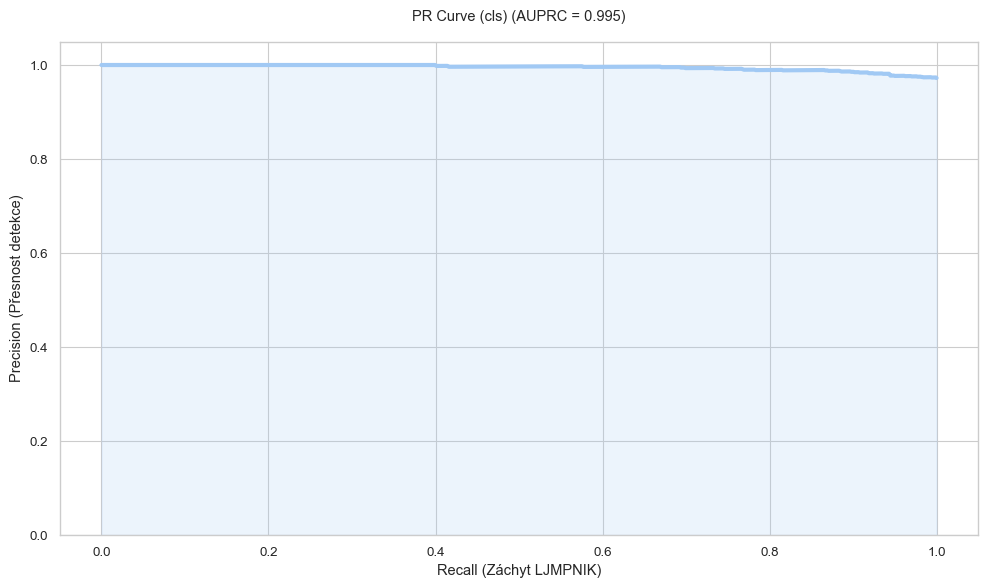

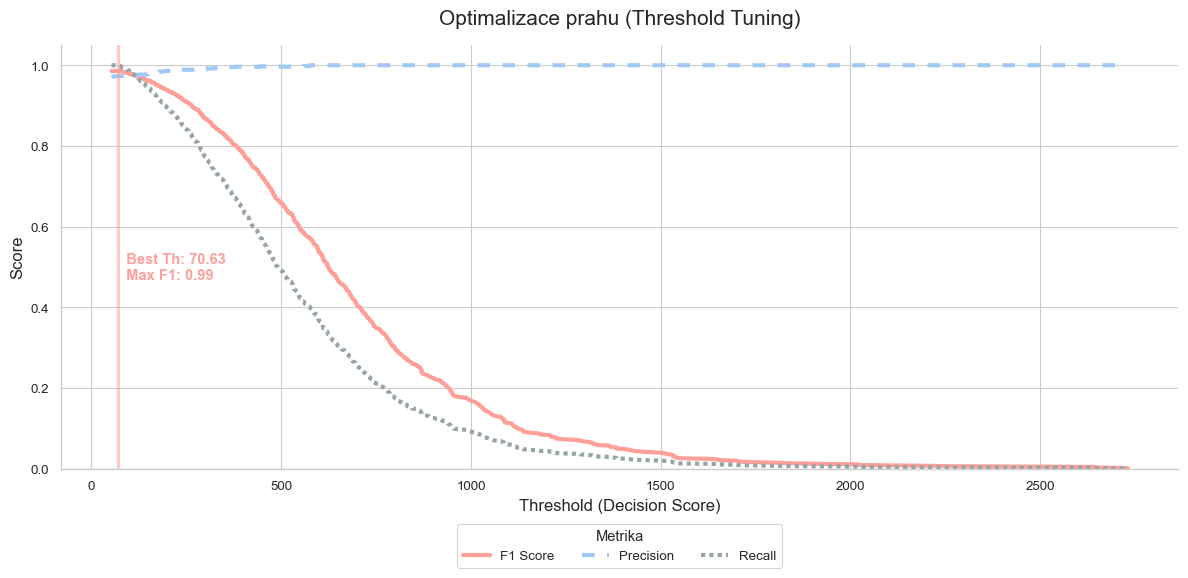

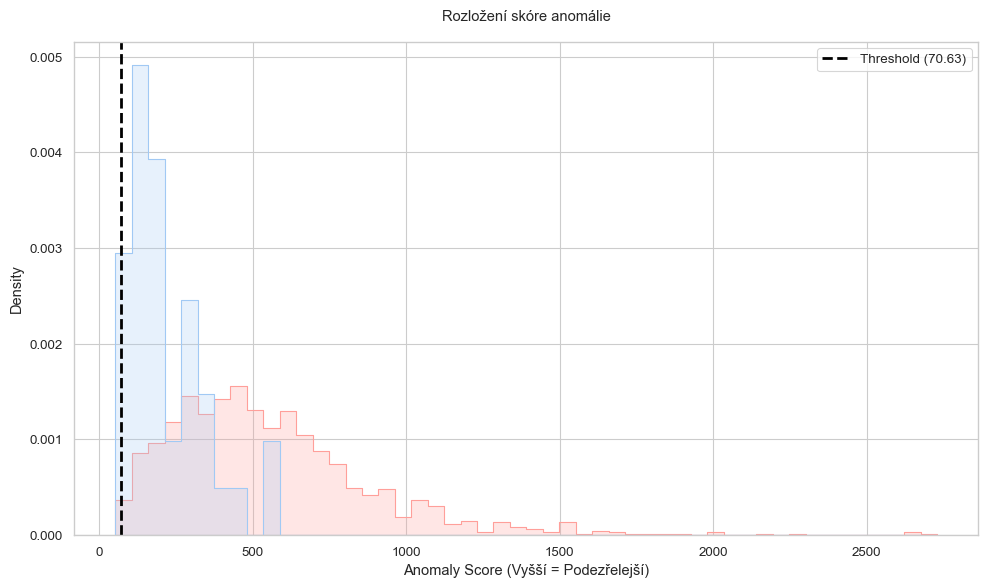

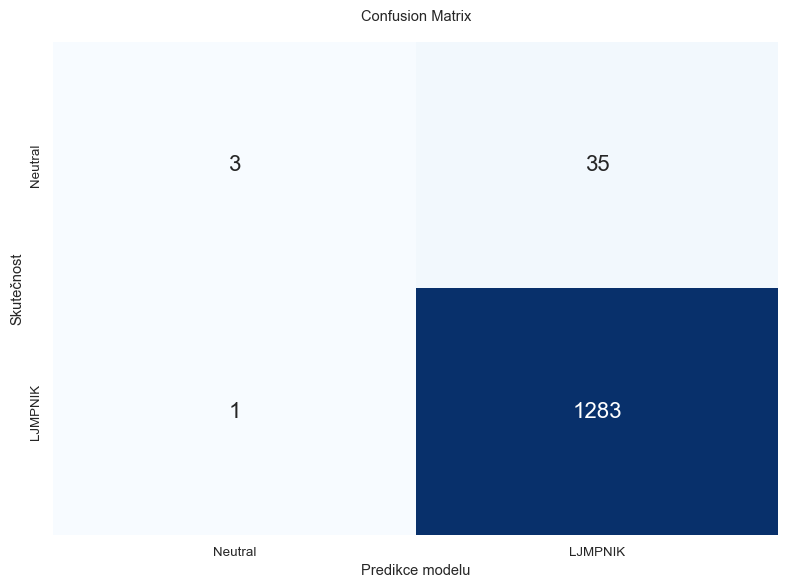

In [13]:
# 3. Vizualizace (Použijeme naše nové funkce)
print("\n📊 Vizualizace:")

viz.plot_pr_curve(y_test, y_scores, title=f"PR Curve ({best_row['pooling']})")

best_th, best_f1 = viz.plot_threshold_tuning(y_test, y_scores)

viz.plot_anomaly_histogram(y_test, y_scores, threshold=best_th)

# 4. Confusion Matrix
y_pred_opt = (y_scores > best_th).astype(int)
viz.plot_confusion_matrix_heatmap(y_test, y_pred_opt)


🗺️ Počítám projekce (PCA, t-SNE, UMAP)...
1️⃣ Počítám PCA...
2️⃣ Počítám t-SNE...
3️⃣ Počítám UMAP...
   -> PCA...


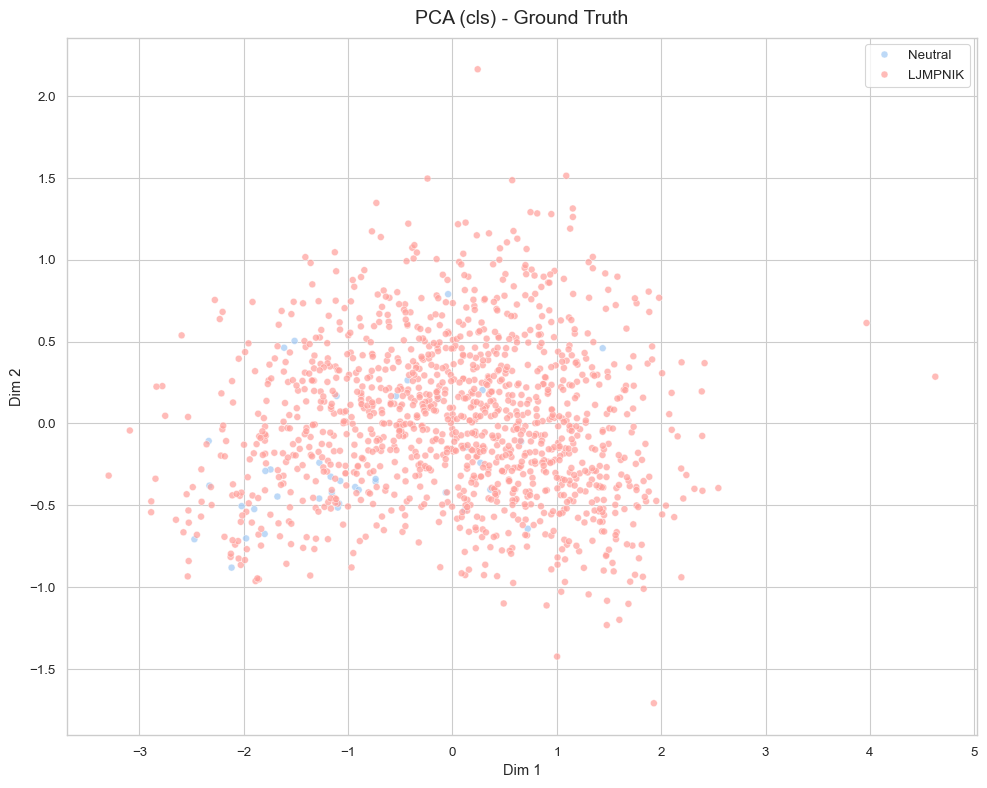

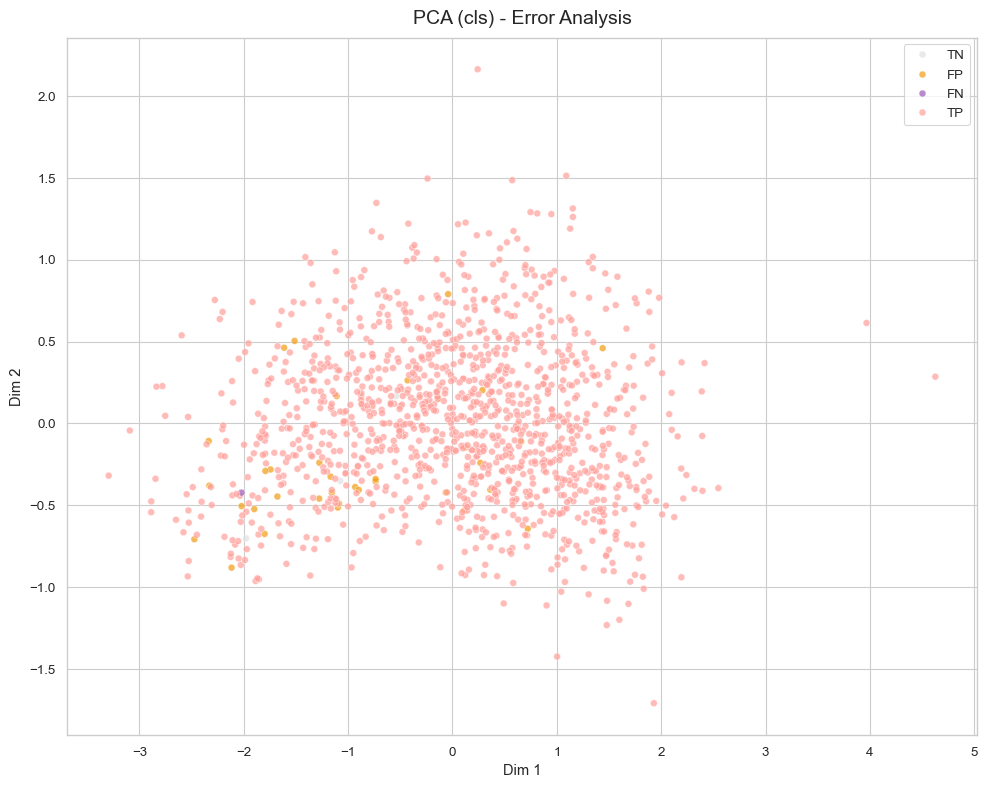

   -> t-SNE...


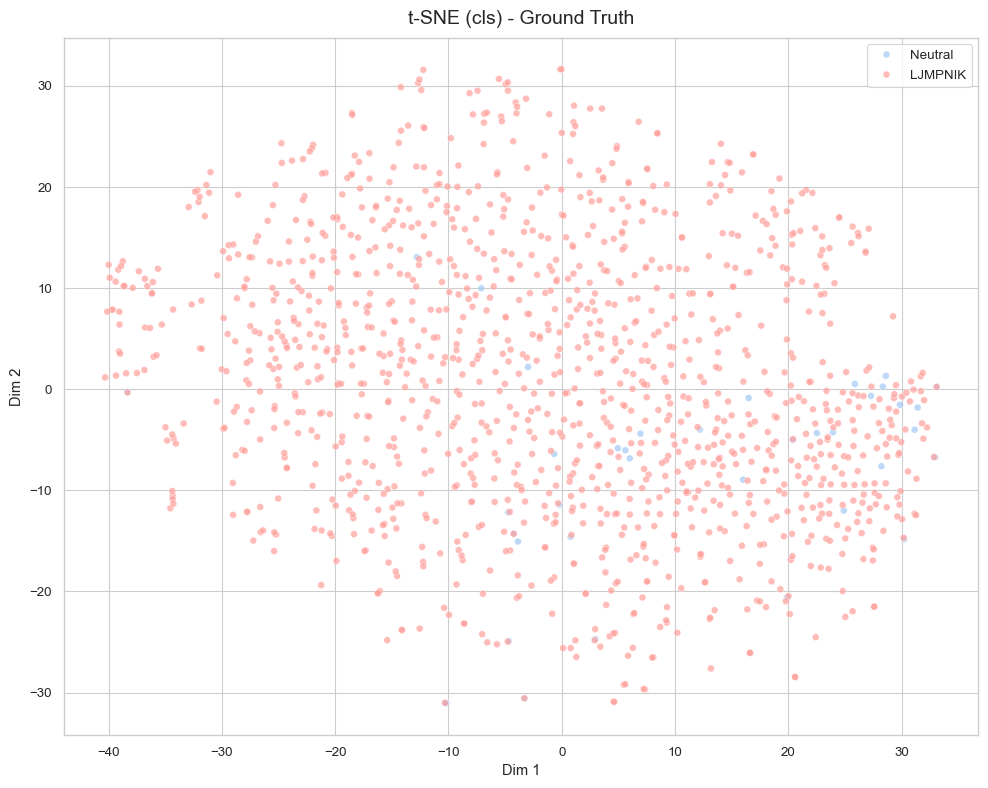

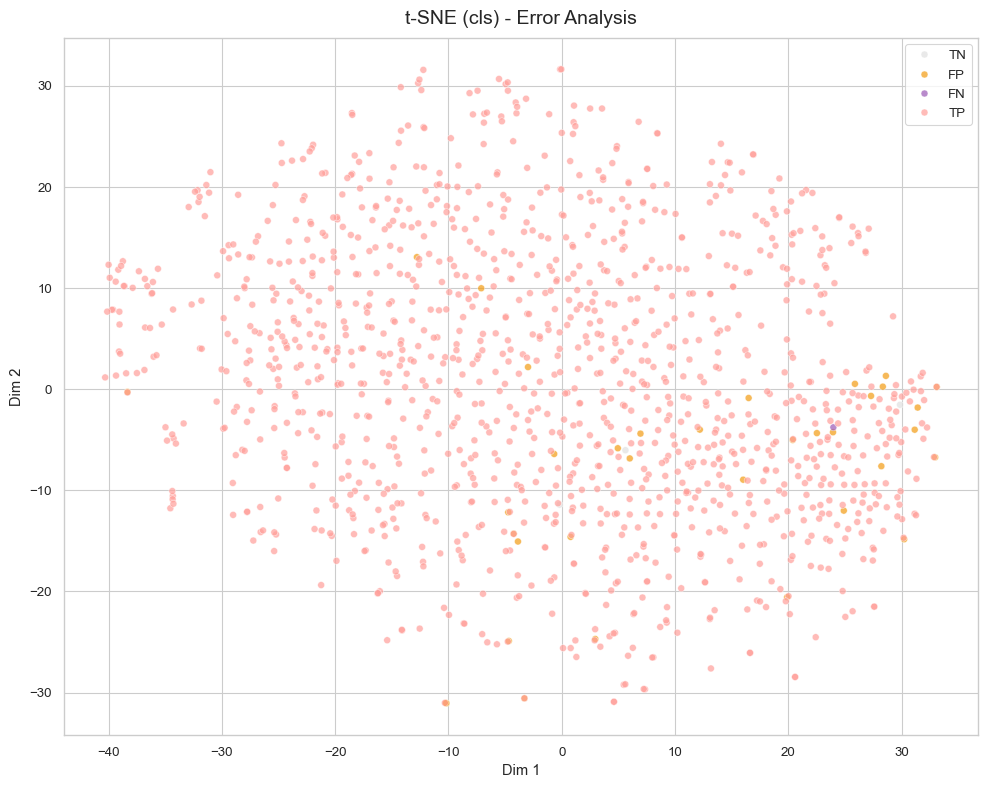

   -> UMAP...


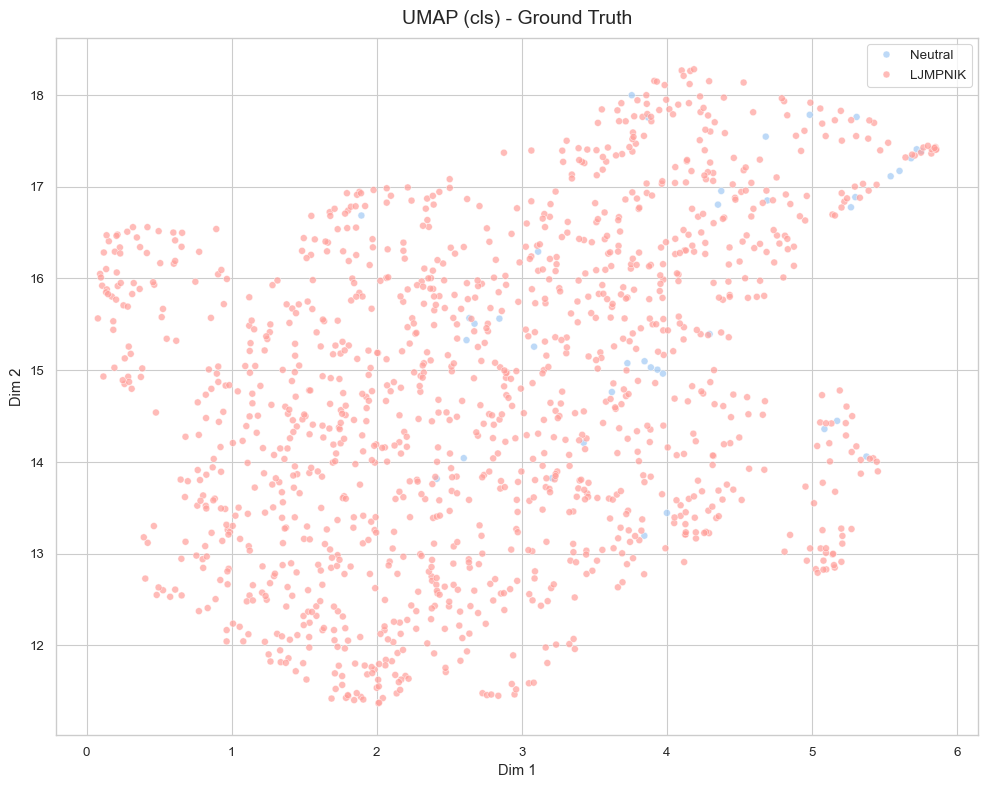

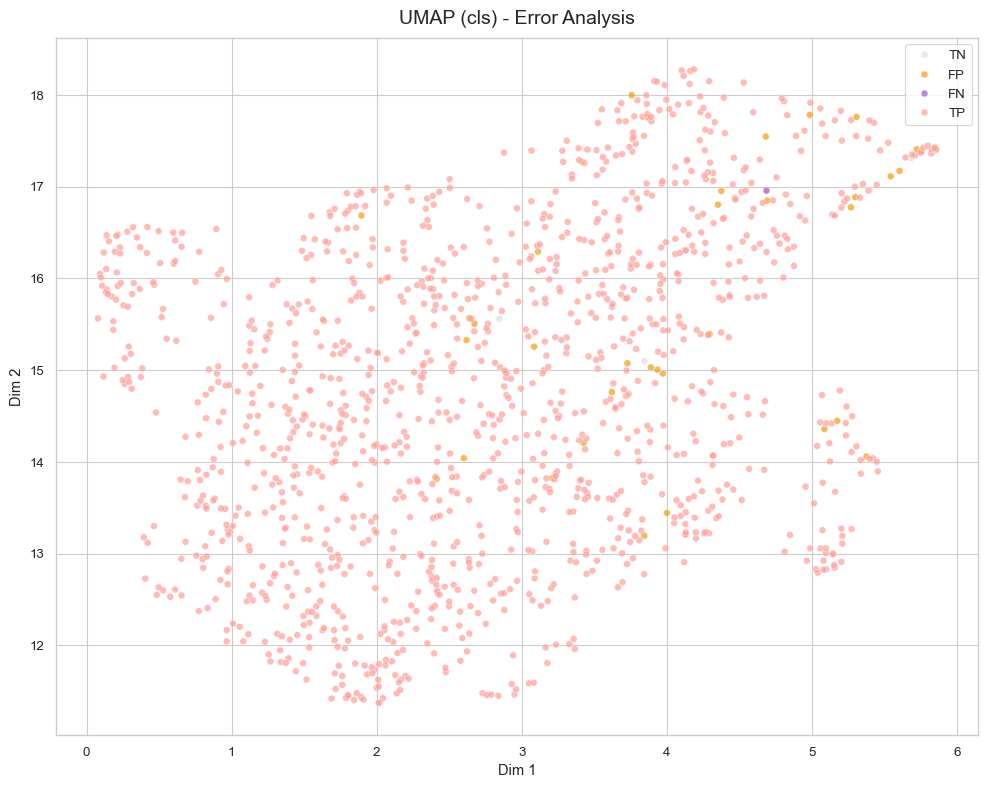

In [14]:
# --- 4. PROJEKCE EMBEDDINGŮ (PCA, t-SNE, UMAP) ---
print("\n🗺️ Počítám projekce (PCA, t-SNE, UMAP)...")

# A) Výpočet projekcí
projections, indices = viz.compute_projections(X_test, methods=['PCA', 't-SNE', 'UMAP'])

# B) Synchronizace dat (kvůli případnému subsamplingu uvnitř compute_projections)
y_viz = y_test[indices]
y_scores_viz = y_scores[indices]
y_pred_viz = (y_scores_viz > best_th).astype(int) # 0/1 predikce podle thresholdu

# C) Definice chyb pro barvení (TP, FP, TN, FN)
conditions = [
    (y_viz == 1) & (y_pred_viz == 1), # TP
    (y_viz == 0) & (y_pred_viz == 1), # FP
    (y_viz == 0) & (y_pred_viz == 0), # TN
    (y_viz == 1) & (y_pred_viz == 0)  # FN
]
choices = ['TP', 'FP', 'TN', 'FN']
error_labels = np.select(conditions, choices, default='Unknown')

# D) Vykreslení smyčkou
palette_gt = {0: config.COLORS['l0'], 1: config.COLORS['l1']}
palette_err = {
    'TP': config.COLORS['TP'], 'FP': config.COLORS['FP'],
    'TN': config.COLORS['TN'], 'FN': config.COLORS['FN']
}
order_err = ['TN', 'FP', 'FN', 'TP']

for method, coords in projections.items():
    print(f"   -> {method}...")
    # Ground Truth
    viz.plot_embedding_projection(
        coords, pd.Series(y_viz).map({0: 'Neutral', 1: 'LJMPNIK'}), 
        palette={'Neutral': config.COLORS['l0'], 'LJMPNIK': config.COLORS['l1']}, 
        title=f"{method} ({best_row['pooling']}) - Ground Truth",
        hue_order=['Neutral', 'LJMPNIK']
    )
    # Error Analysis
    viz.plot_embedding_projection(
        coords, error_labels, palette=palette_err, 
        title=f"{method} ({best_row['pooling']}) - Error Analysis",
        hue_order=order_err
    )